# Custom NN and CNN using PyTorch models for Fashion MNIST case - Classification

---

How to Use This Notebook
---

**Recommended Setup**
- For the best experience, **run this notebook on [Google Colab](https://colab.research.google.com/)**—especially if your local machine is slow.  
- In Colab, **enable GPU support** by going to:  
  `Runtime > Change runtime type > Hardware accelerator > GPU`

This notebook will use PyTorch by making a simple neural network model. Regardless of model's complexity, creating any model can be completed in a similar way. We will use the **Fashion MNIST** dataset, one of the variants of the MNIST dataset. It has the same property as a normal MNIST, with the same size (28*28) and the same number of classes (10), but the images represent fashion items rather than handwritten digits, which means it might have more complexity than normal MNIST.

Because of its complexity in each class, the problem is slightly more challenging than normal MNIST. For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST. Moreover, MNIST is overused. In this April 2017 Twitter thread, Google Brain research scientist and deep learning expert Ian Goodfellow calls for people to move away from MNIST. In addition, MNIST can not represent modern CV tasks, as noted in this April 2017 Twitter thread, deep learning expert/Keras author François Chollet.

Below is an example of Fashion MNIST. What we will do is to create a simple fully connected network model and check its basic performance on Fashion MNIST.


![alt text](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

We will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) from *Zalando Research* data available in github, which has 70,000 article images. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Labels
Each training and test example is assigned to one of the following labels:<br>
0	T-shirt/top<br>
1	Trouser<br>
2	Pullover<br>
3	Dress<br>
4	Coat<br>
5	Sandal<br>
6	Shirt<br>
7	Sneaker<br>
8	Bag<br>
9	Ankle boot

## OUTLINE:

Data pre-processing, plotting and dimensionality reduction, classic ML classification, evaluation.

- Import PyTorch and load a sample dataset
- Sequential fully connected network
- Save the model

### *Library install and dataset load*

You should be able to install PyTorch by using `pip`. You do not need to specify a GPU version.

In [1]:
%%capture
!pip install numpy torch

In [2]:
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from typing import Optional, Callable, Tuple, Dict
from numpy.typing import NDArray

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
from torchsummary import summary

import random

# set seeds
RSEED = 42
pt.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
# version?
pt.__version__

'2.8.0+cu126'

We can import the dataset by using `git clone [repo] [folder]` from the URL link

In [4]:
!git clone https://github.com/zalandoresearch/fashion-mnist.git

fatal: destination path 'fashion-mnist' already exists and is not an empty directory.


#### Dataset handling: Traditional way with scikit-learn

Some Python modules like `torch` and `tensorflow` have their own easy-to-use versions of standard datasets specialised to the specific library. For a fast, but less general alternative to this tutorial, see [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

If the dataset is hosted on github or similar, the first step is to check the description: [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist#get-the-data)

In [5]:
os.listdir('fashion-mnist/data/fashion')

['t10k-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte.gz',
 'train-images-idx3-ubyte.gz',
 'FashionMNIST',
 'train-labels-idx1-ubyte.gz']

Let's load the data:

In [6]:
os.chdir("fashion-mnist")

In [7]:
# load data:
transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root='data/fashion', train=True, download=True,transform=transform)
test_data = datasets.FashionMNIST(root='data/fashion', train=False, download=True,transform=transform)

In [8]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/fashion
    Split: Train
    StandardTransform
Transform: ToTensor()

This dataset is loaded as a NumPy array. We can check the properties of the dataset, for example **shape** or **describe**.

As the dataset is composed of grayscale pixels, the datatype of it is unsigned integer. The dataset also has a pixed range [0, 255] so it does not need to take higher bit than 8. Besides that, PyTorch models are also usually evaluated by one more separate set called validation set as training is an iterative and time-consuming process and we do not know when we need to stop clearly.

To create a validation set, there can be many options, we can explicitly split the dataset using index, or we can just use a training set but with the option stating we want to validate, when we actually fit the model. However, this time we will use scikit-learn's `train_test_split` method to create a validation set as it can provide a nice stratification option.

We need a simple normalization - as we all know the grayscale ranges from 0 to 255...

### *Train-test split*

Here we prepared the class names of the fashion MNIST dataset for your convenience.

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### *Pipelines: optimizing memory consumption*

Imagine taking the above approach with very large datasets (e.g. used for training modern LLMs). Loading all the data before training would exceed RAM and VRAM of almost any computer.

Therefore, we are going to use the [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) API:

---
***An abstract class representing a Dataset.***

*All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite* `__getitem__()`*, supporting fetching a data sample for a given key. Subclasses could also optionally overwrite* `__len__()`*, which is expected to return the size of the dataset by many Sampler implementations and the default options of DataLoader. Subclasses could also optionally implement* `__getitems__()`*, for speedup batched samples loading. This method accepts list of indices of samples of batch and returns list of samples.*

---

#### Dataset Handling

Wrap the raw numpy arrays directly, it works like a list of tuples `(X, y)` in Python. Since the data is very huge, we want to optimize the process of unloading data. Therefore, it should load every single sample dynamically from disk when it is requested and this way keep memory consumption to a minimum. Then, we use the variable `target_dir` as the path to the unzipped data.

In [10]:
from torch.utils.data import Dataset

class FashionMNIST(Dataset):
  def __init__(self, X: NDArray[np.uint8], y: NDArray[np.int64]) -> None:
    self.X = X.astype(np.float32) / 255.0
    self.y = y.astype(np.int64)

  def __len__(self) -> int:
    return len(self.y)

  def __getitem__(self, idx:int) -> Tuple[pt.Tensor, pt.Tensor]:
    # convert to tensor on access
    image = pt.tensor(self.X[idx], dtype=pt.float32).unsqueeze(0)
    label = pt.tensor(self.y[idx])
    return image, label

In [11]:
from sklearn.model_selection import train_test_split

X_train_full = train_data.data.numpy()
y_train_full = train_data.targets.numpy()

X_test = test_data.data.numpy()
y_test = test_data.targets.numpy()

# Stratified split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full,
    test_size=0.5, stratify=y_train_full, random_state=RSEED)

train_data = FashionMNIST(X_train, y_train)
valid_data = FashionMNIST(X_valid, y_valid)
test_data = FashionMNIST(X_test, y_test)

### *Creating the Dataloader*

Our objective is to create a model with the high accuracy on this dataset. Here is our first model!

We use **shuffling and batching**: Using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to easily shuffle and batch the dataset.

In [12]:
BATCH_SIZE = 32

In [13]:
loader_train = DataLoader(train_data,             # dataset from which to the dataloader in a batch.
                          batch_size=BATCH_SIZE,  # how many samples per batch to load (default: 1)
                          shuffle=True,           # set to True to have the data reshuffled at every epoch (default: False)
                          sampler=None,           # defines the strategy to draw samples from the dataset. Can be any Iterable with __len__ implemented.
                                                  # If specified, shuffle must not be specified.
                          batch_sampler=None,     # like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.
                          drop_last=False)        # set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size.
                                                  # If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

In [14]:
# Validation set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
loader_valid = DataLoader(valid_data,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

In [15]:
# Test set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
loader_test  = DataLoader(test_data,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

## *Sequential fully connected network*

#### Instantiating the network:

The standard way to create a PyTorch model is to override the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) class. To create a model you need to override the following methods:
- `__init__(self, ...) -> None`: Initializes the module and instantiates all the layers and functions.
- `forward(self, x) -> y`: implements the forward pass through the network.

When you create a layer (e.g. [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)), you should specify **in_features** and **out_features**.

Summarization of model parameters is only possible when the model has an input information as it needs to calculate the fully connected parameters from the input layer.

Now we are going to setup a version with the following layers:
- One **linear input layer** of 300 perceptrons, with a **ReLu** activation function, followed by a **dropout** layer (use the `dropout` parameter for the ratio).
- One **linear hidden layers** of size 200, with a **ReLu** activation function, followed by **dropout** layers (use the `dropout` parameter for the ratio).
- One **linear output layer**, with a **softmax** activation function.

Assume that `torch.nn` is already imported as `nn`. Furthermore, `torch.nn.functional` is available as `F`.

In [16]:
class CustomNetwork(nn.Module):
    def __init__(self, dropout:float=.2) -> None:
        super(CustomNetwork, self).__init__()
        #continue
        self.input_layer = nn.Linear(in_features=28*28, out_features=300, bias=True)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.hidden_layer = nn.Linear(in_features=300, out_features=200, bias=True)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.output_layer = nn.Linear(in_features=200, out_features=len(class_names), bias=True)

    def forward(self, x:pt.Tensor) -> pt.Tensor:
        #continue

        x = x.view(x.size(0), -1) #flatten the input from (batch_size, 28, 28) to (batch_size, 784)
        x = F.relu(self.input_layer(x))
        x = self.dropout_1(x)
        x = F.relu(self.hidden_layer(x))
        x = self.dropout_2(x)
        return self.output_layer(x)

**Alternative but more restrictive:** `torch.nn.Sequential`

In [17]:
from torch.nn import Sequential

Unnamed layers:

In [18]:
model = Sequential(
    nn.Linear(in_features=28*28, out_features=100, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=len(class_names), bias=True),
    nn.Softmax(dim=-1)
)

In [19]:
# MLP Model summary

model = CustomNetwork()
summary(model, input_size=(784,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
           Dropout-2                  [-1, 300]               0
            Linear-3                  [-1, 200]          60,200
           Dropout-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 297,710
Trainable params: 297,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.14
Estimated Total Size (MB): 1.15
----------------------------------------------------------------


# *Convolutional Neural Network*

## How Convolutional Neural Networks Work?


Convolutional neural networks (CNNs) are commonly used for image classification tasks. At a high level, CNNs contain three main types of layers:

- Convolutional layers: Apply convolutional filters to the input to extract features. The neurons in these layers are called filters and capture spatial patterns in the input.
- Pooling layers: Downsample the feature maps from the convolutional layers to consolidate information. Max pooling and average pooling are commonly used strategies.
- Fully-connected layers: Take the high-level features from the convolutional and pooling layers as input for classification. Multiple fully-connected layers can be stacked.

The convolutional filters act as feature detectors, learning to activate when they see specific types of patterns or shapes in the input image. As these filters are applied across the image, they produce feature maps that highlight where certain features are present.

Padding involves adding extra pixels around the input image’s border.
Padding ensures that the filter fits properly over the image, especially at the edges. Without padding, the feature map’s size reduces after each convolution operation

---

In [20]:
# Simple CNN config: 2 convolutional block, max pooling, dropout, fully connected layers
# 1 channel (28x28 grayscale)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Max pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, len(class_names))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> Pool
        x = self.dropout(x)  # Apply dropout after conv blocks
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = pt.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout in FC layer
        x = self.fc2(x)
        return x

In [21]:
# Model Summary
net = SimpleCNN()
summary(net, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
       BatchNorm2d-5           [-1, 64, 14, 14]             128
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Dropout-7             [-1, 64, 7, 7]               0
            Linear-8                  [-1, 512]       1,606,144
           Dropout-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
Total params: 1,630,282
Trainable params: 1,630,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.68
Params size (MB): 6.22
Estimat

## Integrate the training pipeline for both customNN and CNN

In PyTorch one needs to define which device to use for computation. All tensors involved in the computation need to be on that device. The most common devices are:
- `cpu`: any of your computer's CPUs
- `cpu:0`:the first of your computer's CPUs
- `cuda`: any of your computer's GPUs
- `cuda:2`: the third GPU of you computer

In [22]:
# get gpu if available else cpu:
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
device

device(type='cuda')

Instances of `torch.nn.Module` have a method `.train()` and a method `.eval()` that set the whole module (including submodules) in a training or prediction mode.

This is necessary, as for example dropout layers are inactive during prediction.

In order to train the network, we need to define a training procedure:

How does SGD work?

<img src="https://pantelis.github.io/cs677/docs/common/lectures/optimization/sgd/images/gradient-descent.png" alt="gradient-descent.png" style="width:500px;"/>

Can be improved by:
 - ... reducing the stepsize (i.e. `lr`) towards the end
 - ... using momentum to keep a clear trajectory

The training loop will follow:
1. Utilize basic SGD optimizer with the momentum-based [`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer. **As ADAM is more sensitive to the learning rate, set it to `0.001` after changing the optimizer!**
2. Add a [`torch.optim.lr_scheduler.LinearLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html) scheduler (_start: `1.0*lr`, end:`0.33*lr`, over 10 epochs_). Compare how the learning curves change after this step.
3. Add an **early stopping** functionality, that stops training when the validation loss has not improved for `patience` epochs and restores the model parameters to the ones achieving the best loss. **Use a patience of `5` to retrain the network.**

### *Add EarlyStop + Save the model* using  `torch.save(...)` / `torch.load(...)`

To save to disk whenever a new best model is found.

In [23]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, path="best_model.pt"):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.best_state_dict = None
        self.path = path

    def check_early_stop(self, loss_valid, model):
        if self.best_loss is None or loss_valid < self.best_loss - self.delta:
            self.best_loss = loss_valid
            self.no_improvement_count = 0
            # Save a copy of the model's parameters.
            self.best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            pt.save(model.state_dict(), self.path)
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True




In [24]:
def epoch(model:nn.Module, loader_train:DataLoader, optimizer:pt.optim.Optimizer, loss_fn:Callable[[pt.Tensor, pt.Tensor], pt.Tensor]) -> float:
  # 1. set model to train:
    model.train()
    running = 0.0
    for X, y in loader_train:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        running += loss.item()
    return running / max(1, len(loader_train))

@pt.no_grad()
def evaluate(model: nn.Module,
             loader: DataLoader,
             loss_fn: Optional[Callable[[pt.Tensor, pt.Tensor], pt.Tensor]] = None) -> Dict[str, float]:
    model.eval()
    losses = []
    all_pred, all_true = [], []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        if loss_fn is not None:
            losses.append(loss_fn(logits, y).item())
        pred = logits.argmax(dim=1)
        all_pred.append(pred.cpu())
        all_true.append(y.cpu())
    y_pred = pt.cat(all_pred).numpy()
    y_true = pt.cat(all_true).numpy()
    metrics = {
        "acc": accuracy_score(y_true, y_pred),
        "f1":  f1_score(y_true, y_pred, average="macro"),
    }
    if loss_fn is not None:
        metrics["loss"] = float(np.mean(losses)) if len(losses) else float("nan")
    return metrics

def fit(model: nn.Module,
        loader_train: DataLoader,
        loader_valid: DataLoader,
        *,
        epochs: int = 20,
        lr: float = 1e-3,
        patience: int = 5,
        momentum: float = 0.9,
        model_name: str = "model") -> pd.DataFrame:
    model = model.to(device)
    loss_fn   = nn.CrossEntropyLoss()
    optimizer = pt.optim.Adam(model.parameters(), lr=lr)

    # Same scheduler for both models (fairness)
    scheduler = pt.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.33, total_iters=10)
    es = EarlyStopping(patience=patience, path=f"{model_name}_best.pt")

    history = []
    for ep in range(1, epochs+1):
        train_loss = epoch(model, loader_train, optimizer, loss_fn)
        val_metrics = evaluate(model, loader_valid, loss_fn)
        scheduler.step(val_metrics["loss"])

        history.append({
            "epoch": ep,
            "loss_train": train_loss,
            "loss_valid": val_metrics["loss"],
            "acc_valid":  val_metrics["acc"],
            "f1_valid":   val_metrics["f1"],
            "lr": optimizer.param_groups[0]["lr"],
        })

        es.check_early_stop(val_metrics["loss"], model)
        if es.stop_training:
            break

    # Load the best weights before returning
    model.load_state_dict(pt.load(f"{model_name}_best.pt", map_location=device))
    return pd.DataFrame(history), model

# Instantiate both model

In [25]:
COMMON = dict(epochs=20, lr=1e-3, patience=5)  # identical for both

# MLP
mlp = CustomNetwork().to(device)
early_stopping = EarlyStopping(patience=5)
mlp_hist, mlp_best = fit(mlp, loader_train, loader_valid, model_name="mlp", **COMMON)
mlp_val = mlp_hist.iloc[-1]  # last logged epoch (note: weights are best)
mlp_test = evaluate(mlp_best, loader_test, loss_fn=nn.CrossEntropyLoss())

# CNN
cnn = SimpleCNN()
cnn_hist, cnn_best = fit(cnn, loader_train, loader_valid, model_name="cnn", **COMMON)
cnn_val = cnn_hist.iloc[-1]
cnn_test = evaluate(cnn_best, loader_test, loss_fn=nn.CrossEntropyLoss())

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://gith

In [26]:
# Compare in a table
summary = pd.DataFrame([
    {"model": "MLP",
     "best_val_loss": mlp_val["loss_valid"], "best_val_acc": mlp_val["acc_valid"], "best_val_f1": mlp_val["f1_valid"],
     "test_loss": cnn_test["loss"] if "loss" in mlp_test else float("nan"),  # evaluate() returns loss when loss_fn provided
     "test_acc":  mlp_test["acc"], "test_f1": mlp_test["f1"]},
    {"model": "CNN",
     "best_val_loss": cnn_val["loss_valid"], "best_val_acc": cnn_val["acc_valid"], "best_val_f1": cnn_val["f1_valid"],
     "test_loss": cnn_test["loss"], "test_acc": cnn_test["acc"], "test_f1": cnn_test["f1"]},
])
summary


,model,best_val_loss,best_val_acc,best_val_f1,test_loss,test_acc,test_f1
0,MLP,0.335776,0.882467,0.881431,0.244497,0.8752,0.875077
1,CNN,0.237160,0.924233,0.924281,0.244497,0.9174,0.917498


### *Visualization*

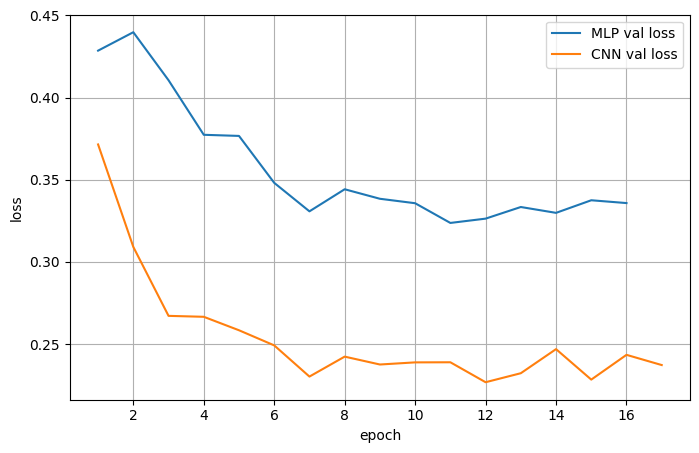

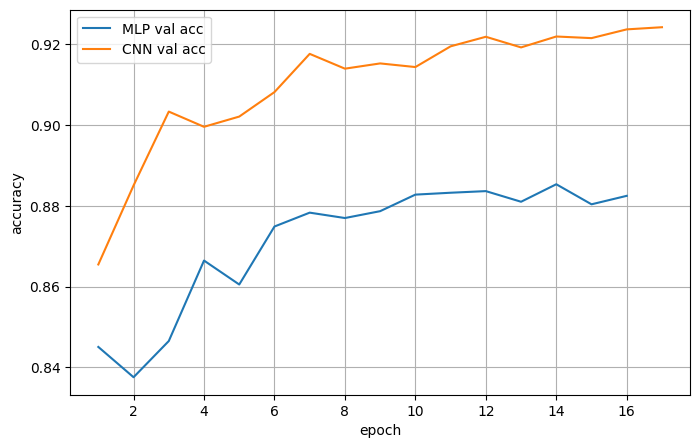

In [27]:


plt.figure(figsize=(8,5))
plt.plot(mlp_hist["epoch"], mlp_hist["loss_valid"], label="MLP val loss")
plt.plot(cnn_hist["epoch"], cnn_hist["loss_valid"], label="CNN val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(mlp_hist["epoch"], mlp_hist["acc_valid"], label="MLP val acc")
plt.plot(cnn_hist["epoch"], cnn_hist["acc_valid"], label="CNN val acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.grid(True); plt.show()

## Visualizing CNN Kernels and Feature Maps

To understand what the CNN is learning, we can visualize:
- **Kernels (filters)**: The raw weights of convolution layers
- **Feature maps (activations)**: What the filters detect in a specific input image

These help us build intuition about how the model 'sees' the image at each stage.

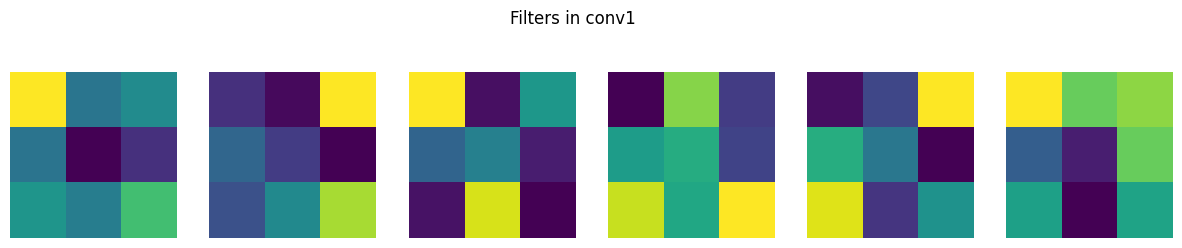

In [28]:
# Kernels

# Get the weights and normalize to [0, 1]
filters = net.conv1.weight.data.clone().cpu()
filters = (filters - filters.min()) / (filters.max() - filters.min())

# Plot first 6 filters
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axes[i].imshow(filters[i].permute(1, 2, 0))  # convert CHW to HWC
    axes[i].axis('off')
plt.suptitle('Filters in conv1')
plt.show()

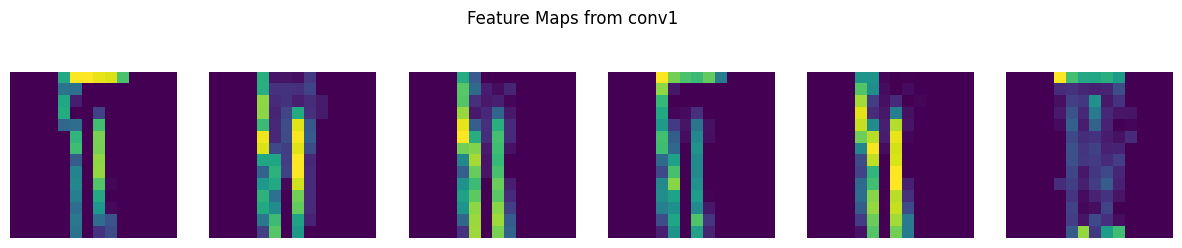

In [29]:
# Feature Maps
# Choose one sample image from Fashion-MNIST
image, label = train_data[0]
input_img = image.unsqueeze(0).to(device)  # Add batch dimension

# Pass through first conv layer and visualize
cnn=cnn.to(device)
cnn.eval()
with pt.no_grad():
    activation = cnn.pool(pt.relu(cnn.bn1(cnn.conv1(input_img))))

# Remove batch dimension and convert to CPU
features = activation.squeeze().cpu()

# Plot first 6 feature maps
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axes[i].imshow(features[i] ) #cmap='gray'
    axes[i].axis('off')
plt.suptitle('Feature Maps from conv1')
plt.show()

## The End